In [1]:
import torchvision
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.supervised import Naive
from avalanche.models import SlimResNet18
from avalanche.benchmarks import with_task_labels, benchmark_from_datasets
from utils import load_CLEAR, build_CLEAR_train_experiences, build_CLEAR_test_experiences
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics

In [2]:
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
CLEAR_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((32, 32)),
            #normalize,
        ]
    )
train_path = '/Users/marcodamommio/2023-2024_OCL_Class-Incremental/train/labeled_images'
test_path = '/Users/marcodamommio/2023-2024_OCL_Class-Incremental/test/labeled_images'
train_dict = load_CLEAR(train_path, transform=CLEAR_transform)
test_dict = load_CLEAR(test_path, transform=CLEAR_transform)

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


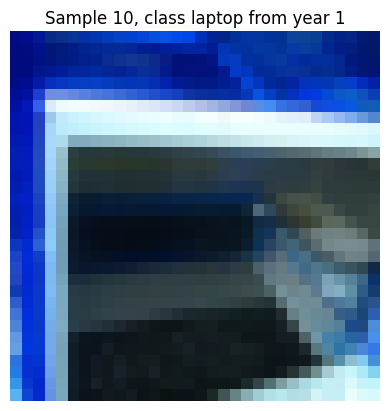

In [3]:
year_folder_name = '1'
class_folder_name = 'laptop'
images_array = test_dict[year_folder_name][class_folder_name]

elem = 10
plt.imshow(images_array[elem].permute(1,2,0))
plt.axis('off') 
plt.title(f'Sample {elem}, class {class_folder_name} from year {year_folder_name}')
plt.show()

In [4]:
classes_pairs = [
    ('BACKGROUND', 'baseball'),
    ('bus', 'camera'),
    ('cosplay', 'dress'),
    ('hockey', 'laptop'),
    ('racing', 'soccer'),
    ('sweater', None)   
]

In [24]:
train_experiences = build_CLEAR_train_experiences(train_dict, classes_pairs)
test_experiences = build_CLEAR_test_experiences(test_dict, classes_pairs)

In [30]:
from avalanche.benchmarks.scenarios.online import split_online_stream

In [31]:
bm = benchmark_from_datasets(
        train=test_experiences
    )

In [32]:
bm.train_stream

In [33]:
chec = split_online_stream(bm.train_stream, experience_size=10, shuffle=False)

In [39]:
for exp in chec:
    print(f"Experience {exp.current_experience}")
    print(f"\tsize: {len(exp.dataset)}")
    print(f"\ttarget: {exp.dataset.targets}")

Experience 0
	size: 10
	target: FlatData (len=10,subset=True,cat=False,cf=True)
	DataAttribute (len=1000)

Experience 1
	size: 10
	target: FlatData (len=10,subset=True,cat=False,cf=True)
	DataAttribute (len=1000)

Experience 2
	size: 10
	target: FlatData (len=10,subset=True,cat=False,cf=True)
	DataAttribute (len=1000)

Experience 3
	size: 10
	target: FlatData (len=10,subset=True,cat=False,cf=True)
	DataAttribute (len=1000)

Experience 4
	size: 10
	target: FlatData (len=10,subset=True,cat=False,cf=True)
	DataAttribute (len=1000)

Experience 5
	size: 10
	target: FlatData (len=10,subset=True,cat=False,cf=True)
	DataAttribute (len=1000)

Experience 6
	size: 10
	target: FlatData (len=10,subset=True,cat=False,cf=True)
	DataAttribute (len=1000)

Experience 7
	size: 10
	target: FlatData (len=10,subset=True,cat=False,cf=True)
	DataAttribute (len=1000)

Experience 8
	size: 10
	target: FlatData (len=10,subset=True,cat=False,cf=True)
	DataAttribute (len=1000)

Experience 9
	size: 10
	target: FlatD

In [16]:
check = list(chec)
check

AttributeError: 'ClassificationDataset' object has no attribute 'dataset'

In [12]:
test_experiences[0].targets[499]

0

In [6]:
bm = with_task_labels(
    benchmark_from_datasets(
        train=train_experiences,
        test=test_experiences
    )
)
bm

AttributeError: 'ClassificationDataset' object has no attribute 'targets_task_labels'

In [ ]:
model = SlimResNet18(nclasses=11, nf=5)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()
loggers = [InteractiveLogger()]
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=loggers
)
cl_strategy = Naive(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion,
    train_mb_size=10,
    train_epochs=1, 
    eval_mb_size=64,
    evaluator=eval_plugin
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2834222440.py, line 9)

In [56]:
# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in bm.train_stream[:10]:
    print("Start of experience: ", experience.current_experience)

    # in Avalanche an experience may have multiple task labels
    # if the samples in its dataset come from different tasks
    # here we just have one task label per experience
    print(f"\tTask labels: {experience.task_labels}")

    cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(bm.test_stream))


Starting experiment...
Start of experience:  0
	Task labels: {0}
-- >> Start of training phase << --
100%|██████████| 1/1 [00:00<00:00, 34.17it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2096
	Loss_MB/train_phase/train_stream/Task000 = 1.2096
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0300
	Time_Epoch/train_phase/train_stream/Task000 = 0.0300
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 16/16 [00:00<00:00, 39.33it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 2.0353
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 16/16 [00:00<00:

In [57]:
metrics = eval_plugin.get_all_metrics()

In [58]:
print('\n'.join(list(metrics.keys())))

Top1_Acc_MB/train_phase/train_stream/Task000
Loss_MB/train_phase/train_stream/Task000
RunningTime_Epoch/train_phase/train_stream/Task000
Top1_Acc_Epoch/train_phase/train_stream/Task000
Loss_Epoch/train_phase/train_stream/Task000
Time_Epoch/train_phase/train_stream/Task000
Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000
Loss_Exp/eval_phase/test_stream/Task000/Exp000
Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001
Loss_Exp/eval_phase/test_stream/Task001/Exp001
Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002
Loss_Exp/eval_phase/test_stream/Task002/Exp002
Top1_Acc_Exp/eval_phase/test_stream/Task003/Exp003
Loss_Exp/eval_phase/test_stream/Task003/Exp003
Top1_Acc_Exp/eval_phase/test_stream/Task004/Exp004
Loss_Exp/eval_phase/test_stream/Task004/Exp004
Top1_Acc_Exp/eval_phase/test_stream/Task005/Exp005
Loss_Exp/eval_phase/test_stream/Task005/Exp005
Top1_Acc_Stream/eval_phase/test_stream/Task005
Loss_Stream/eval_phase/test_stream/Task005
StreamForgetting/eval_phase/test_stream
Confusion

In [59]:
metrics['Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000']

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.986,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0])

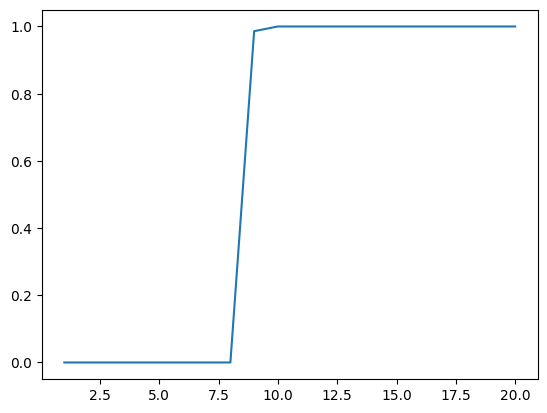

In [62]:
exp, loss = metrics['Loss_MB/train_phase/train_stream/Task000']
exp, acc = metrics['Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000']
plt.plot(exp, acc)